# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached https://files.pythonhosted.org/packages/e9/ed/5853ec0ae380cba4588eab1524e18ece1583b65f7ae0e97321f5ff9dfd60/tensorflow_estimator-2.3.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/36/16/cfba8fcd817df923827233115df35dc048af12d0afa13df79b303865855a/protobuf-3.20.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/a7/f1/f89e097f377b163856076f167baf149b010df3bbf425d2c06276048e2051/tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e0/68/e8ecfac5dd594b676c23a7f07ea34c197d7d69b3313afdf8ac1b0a9905a2/tensorboard_plugin_wit-1.8.1-py3-none-any.whl
  S

ERROR: tensorflow-text 2.8.2 requires tensorflow-hub>=0.8.0, which is not installed.
ERROR: tensorflow-text 2.8.2 has requirement tensorflow<2.9,>=2.8.0; platform_machine != "arm64" or platform_system != "Darwin", but you'll have tensorflow 2.3.1 which is incompatible.
ERROR: scikit-image 0.19.2 has requirement numpy>=1.17.0, but you'll have numpy 1.16.4 which is incompatible.
ERROR: scikit-image 0.19.2 has requirement scipy>=1.4.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: pywavelets 1.3.0 has requirement numpy>=1.17.3, but you'll have numpy 1.16.4 which is incompatible.
ERROR: labelme 5.0.1 has requirement matplotlib<3.3, but you'll have matplotlib 3.5.1 which is incompatible.
ERROR: tensorflow-gpu 2.8.0 has requirement numpy>=1.20, but you'll have numpy 1.16.4 which is incompatible.


### 1.2 Collect Images Using OpenCV

In [6]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [9]:
!labelme

[INFO   ] __init__:get_config:71 - Loading config file from: C:\Users\User\.labelmerc
External WM_DESTROY received for  QWidgetWindow(0x1f7e759d270, name="LabelDialogClassWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x1f7e1145730, name="MainWindowClassWindow")


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [7]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [25]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [26]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [27]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [28]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [9]:
images.as_numpy_iterator().next()

array([[[145, 186, 190],
        [146, 187, 191],
        [146, 187, 191],
        ...,
        [ 92, 150, 154],
        [112, 167, 170],
        [147, 202, 205]],

       [[145, 186, 190],
        [146, 187, 191],
        [146, 187, 191],
        ...,
        [114, 169, 174],
        [ 87, 140, 144],
        [144, 197, 201]],

       [[145, 186, 190],
        [146, 187, 191],
        [144, 188, 191],
        ...,
        [140, 193, 199],
        [ 79, 130, 134],
        [118, 169, 173]],

       ...,

       [[ 33,  38,  34],
        [ 28,  28,  26],
        [ 27,  18,  19],
        ...,
        [ 53, 139, 172],
        [ 55, 139, 173],
        [ 42, 125, 159]],

       [[ 42,  41,  37],
        [ 39,  35,  32],
        [ 36,  27,  28],
        ...,
        [ 52, 141, 171],
        [ 55, 140, 171],
        [ 54, 139, 170]],

       [[ 45,  41,  38],
        [ 47,  42,  39],
        [ 50,  41,  42],
        ...,
        [ 55, 144, 174],
        [ 56, 143, 173],
        [ 57, 142, 173]]

In [10]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

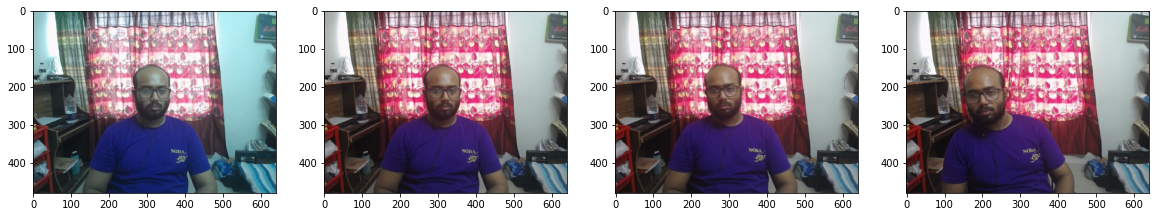

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [15]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [4]:
import albumentations as alb
import cv2

In [2]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [11]:
img = cv2.imread(os.path.join('data','train', 'images','35b42236-d26b-11ec-8a44-b42e99c8cac2.jpg'))

In [12]:
with open(os.path.join('data', 'train', 'labels', '35b42236-d26b-11ec-8a44-b42e99c8cac2.json'), 'r') as f:
    label = json.load(f)

In [14]:
label['shapes'][0]['points']
# label

[[254.84834123222748, 139.33649289099526],
 [371.436018957346, 290.04739336492895]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [15]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [16]:
coords

[254.84834123222748, 139.33649289099526, 371.436018957346, 290.04739336492895]

In [17]:
coords = list(np.divide(coords, [640,480,640,480]))

In [18]:
coords

[0.3982005331753554,
 0.29028436018957343,
 0.5803687796208531,
 0.604265402843602]

### 4.4 Apply Augmentations and View Results

In [19]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [20]:
augmented['bboxes'][0][2:]

(0.7698578199052133, 0.7348077935755661)

In [21]:
augmented['bboxes']

[(0.5107740916271721,
  0.39989468141126905,
  0.7698578199052133,
  0.7348077935755661)]

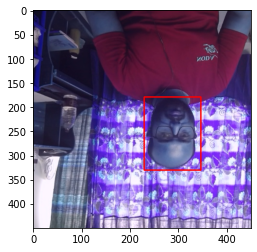

In [22]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [23]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [29]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [30]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [31]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [32]:
train_images.as_numpy_iterator().next()

array([[[0.31672794, 0.40251225, 0.33768383],
        [0.3403799 , 0.38253677, 0.3918505 ],
        [0.33743873, 0.3791054 , 0.38694853],
        ...,
        [0.9416054 , 0.8831495 , 0.9341299 ],
        [0.7949755 , 0.75441176, 0.798223  ],
        [0.98468137, 0.9506127 , 0.9862132 ]],

       [[0.3370711 , 0.40471813, 0.35569853],
        [0.3372549 , 0.37561274, 0.38045344],
        [0.3372549 , 0.3768995 , 0.38474265],
        ...,
        [0.86243874, 0.7987132 , 0.85018384],
        [0.8584559 , 0.81740195, 0.85447305],
        [0.9053309 , 0.8661152 , 0.9014093 ]],

       [[0.3332108 , 0.39693627, 0.37389705],
        [0.33216912, 0.37873775, 0.37971812],
        [0.32947305, 0.3726103 , 0.38045344],
        ...,
        [0.8327206 , 0.7631127 , 0.80968136],
        [0.9629902 , 0.93308824, 0.96544117],
        [0.99785537, 0.959375  , 0.9928309 ]],

       ...,

       [[0.3617647 , 0.5181373 , 0.59705883],
        [0.3841299 , 0.5272059 , 0.58707106],
        [0.5134191 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [33]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [34]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [36]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [37]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.5747, 0.2563, 0.8335, 0.5913], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [38]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [39]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [40]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [41]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [42]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8), array([[0.1866, 0.4631, 0.39  , 0.7285],
        [0.4763, 0.2737, 0.7393, 0.632 ],
        [0.5977, 0.315 , 0.817 , 0.577 ],
        [0.3828, 0.3704, 0.6484, 0.718 ],
        [0.6006, 0.3276, 0.8345, 0.5825],
        [0.4478, 0.4155, 0.6763, 0.663 ],
        [0.3787, 0.4282, 0.6514, 0.7676],
        [0.8027, 0.4626, 1.    , 0.7173]], dtype=float16))

### 7.3 View Images and Annotations

In [43]:
data_samples = train.as_numpy_iterator()

In [44]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


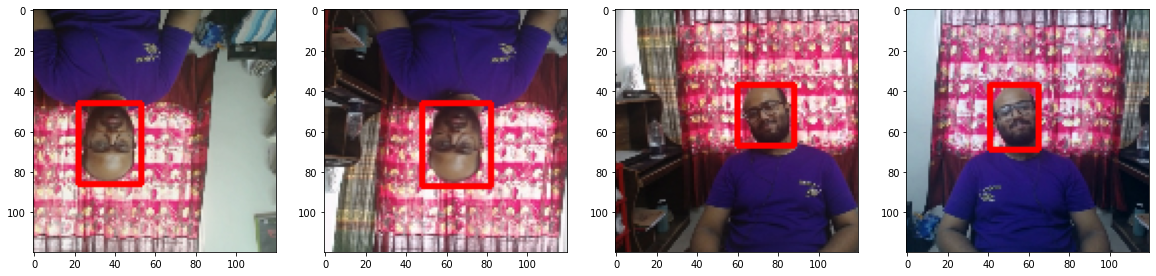

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [47]:
vgg = VGG16(include_top=False)

58900480/58889256 [==============================] - 19s 0us/step


In [48]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [49]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [50]:
facetracker = build_model()

In [51]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [53]:
X, y = train.as_numpy_iterator().next()

In [54]:
X.shape

(8, 120, 120, 3)

In [55]:
classes, coords = facetracker.predict(X)

In [56]:
classes, coords

(array([[0.30232906],
        [0.29538932],
        [0.30964136],
        [0.21973237],
        [0.30897665],
        [0.3189677 ],
        [0.2985453 ],
        [0.31946158]], dtype=float32),
 array([[0.5341958 , 0.5556819 , 0.5025746 , 0.3460454 ],
        [0.49000326, 0.54583704, 0.5454985 , 0.3744002 ],
        [0.5683845 , 0.47303241, 0.5407783 , 0.4658878 ],
        [0.46077147, 0.5376629 , 0.43006787, 0.45108426],
        [0.5645942 , 0.5834928 , 0.5468907 , 0.435289  ],
        [0.56712514, 0.49952963, 0.54456234, 0.45509177],
        [0.49850413, 0.5429393 , 0.53362983, 0.3811817 ],
        [0.49326175, 0.5197257 , 0.5251914 , 0.41780105]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [57]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [58]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [59]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [60]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [61]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5581017>

In [62]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.114532>

In [63]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5581017>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [64]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [65]:
model = FaceTracker(facetracker)

In [66]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [67]:
logdir='logs'

In [68]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [69]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - ETA: 0s - total_loss: 0.1004 - class_loss: 0.0256 - regress_loss: 0.0876

KeyboardInterrupt: 

### 10.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()